## Imports

In [10]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt

from monai.inferers import sliding_window_inference
from monai.config import print_config


import torch
#import pytorch_lightning
import lightning
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from monai_unet import Net


In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)
torch.backends.cudnn.benchmark = True
print_config()

device =  cuda
MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: c:\awilde\<username>a\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.1+cu124
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml ver

## Setup data directory

In [12]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\britt\AppData\Local\Temp\tmp28yogr4q


## Run the training

In [13]:
torch.set_float32_matmul_precision('medium')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [14]:
# initialise the LightningModule
net = Net(device)

# set up checkpoints
# TODO model callback set when val_loss lowest
checkpoint_callback = ModelCheckpoint(dirpath="./heart_data_lightning_models/", filename='{epoch}-{val_loss:.2f}-{val_dice:.2f}', monitor="val_dice", mode="max")
early_stopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=10)
max_epochs = 120

# initialise Lightning's trainer.
trainer = lightning.Trainer(
    devices=[0],
    max_epochs=max_epochs,
    #check_val_every_n_epoch=net.check_val,
    callbacks=[checkpoint_callback, early_stopping_callback],
    #callbacks=[checkpoint_callback],
    default_root_dir=root_dir,
    log_every_n_steps=4,
)

# train
trainer.fit(net)

c:\awilde\britta\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 16/16 [00:00<?, ?it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading dataset: 100%|██████████| 16/16 [00:00<?, ?it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | _model        | UNet       | 4.8 M  | train
1 | loss_function | DiceCELoss | 0      | train
-----------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M  

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]current epoch: 0 current val_loss: 79.37482452392578 current mean dice: 0.0091
best mean dice: 0.0091 at epoch: 0
Epoch 0: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s, v_num=0]          current epoch: 0 current val_loss: 1.3882533311843872 current mean dice: 0.0222
best mean dice: 0.0222 at epoch: 0
Epoch 1: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s, v_num=0]current epoch: 1 current val_loss: 1.2827028036117554 current mean dice: 0.0236
best mean dice: 0.0236 at epoch: 1
Epoch 2: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s, v_num=0]current epoch: 2 current val_loss: 1.2251579761505127 current mean dice: 0.0136
best mean dice: 0.0236 at epoch: 1
Epoch 3: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s, v_num=0]current epoch: 3 current val_loss: 1.2073769569396973 current mean dice: 0.0108
best mean dice: 0.0236 at epoch: 1
Epoch 4: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s, v_num=0]current epoch: 4

## Plot the loss and metric

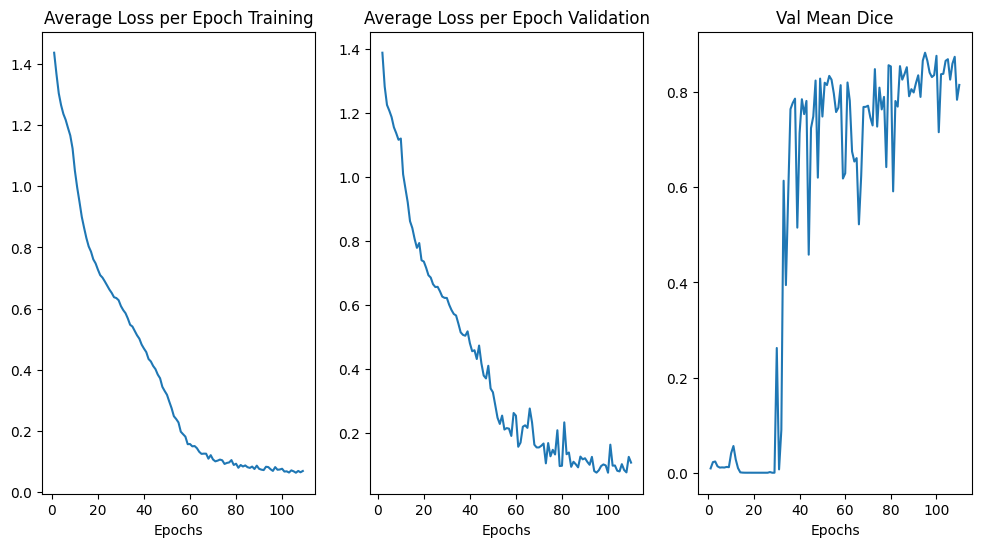

In [15]:
epochs = max_epochs
plt.figure("train", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Average Loss per Epoch Training")
x = [i for i in range(1,len(net.epoch_train_loss)+1)]
y = net.epoch_train_loss
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 2)
plt.title("Average Loss per Epoch Validation")
# skip first epoch for validation loss as it is very high
x = [i for i in range(2,len(net.epoch_val_loss)+1)]
y = net.epoch_val_loss[1:]
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice")
x = [i for i in range(1,len(net.metric_values)+1)]
y = net.metric_values
plt.xlabel("Epochs")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [16]:
model = Net.load_from_checkpoint(checkpoint_callback.best_model_path, device = device)
model.eval()
model.to(device)

Loading dataset: 100%|██████████| 16/16 [00:00<?, ?it/s]


Net(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.2, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.2, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        (submodule): Sequ

In [17]:
images = []
outputs = []
labels = []
val_loader = model.val_dataloader()
for val_data in val_loader: 
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
    )
    images.append(val_inputs)
    outputs.append(model.forward(val_inputs))
    labels.append(val_labels)

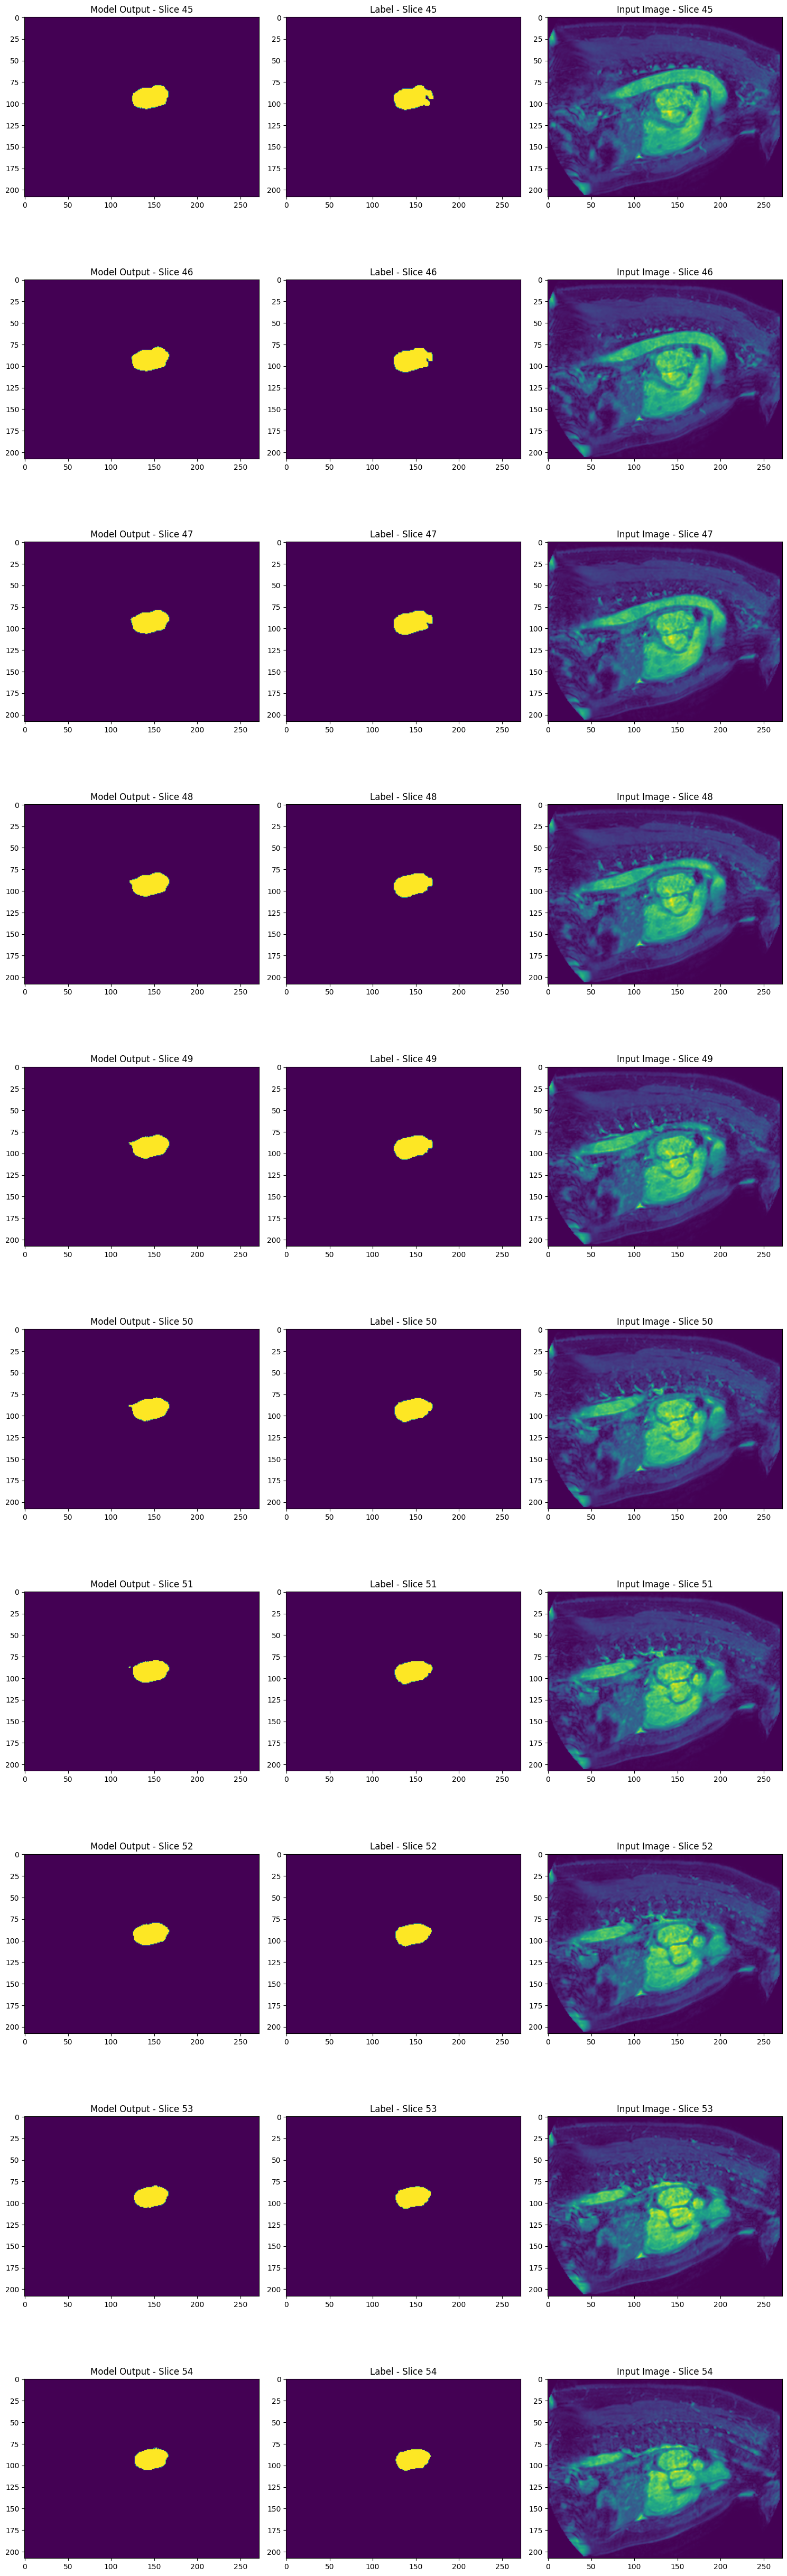

In [18]:
# Assuming outputs, labels, and images are your variables
output = outputs[0]
label = labels[0][0][0]
image = images[0][0][0]

# Set the slice range from 45 to 50
slice_start = 45
slice_end = 55

# Calculate the number of slices
num_slices = slice_end - slice_start

# Create a subplot with 'num_slices' rows and 3 columns
plt.figure(figsize=(15, 5 * num_slices))

for i in range(num_slices):
    # Increment the slice index
    current_slice = slice_start + i
    
    # Plot the Model Output
    plt.subplot(num_slices, 3, 3 * i + 1)
    with torch.no_grad():
        plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
    plt.title(f'Model Output - Slice {current_slice}')

    # Plot the Label
    plt.subplot(num_slices, 3, 3 * i + 2)
    plt.imshow(label.cpu()[:, :, current_slice])
    plt.title(f'Label - Slice {current_slice}')

    # Plot the Input Image
    plt.subplot(num_slices, 3, 3 * i + 3)
    plt.imshow(image.cpu()[:, :, current_slice])
    plt.title(f'Input Image - Slice {current_slice}')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()